In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from falkon import Falkon, kernels
from falkon.mmv_ops import batch_mmv
from falkon import FalkonOptions
from falkon.utils import devices

## Set data dimensions

In [3]:
num_parallel = 150
N = 1900
M = 2000
D = 1024
cuda = True

## Create synthetic data

In [4]:
def gen_data(B, N, M, D, cuda):
    X = torch.randn(B, N, D)
    W = torch.randn(B, M, D)
    alpha = torch.randn(B, M, 1)
    if cuda:
        X, W, alpha = X.cuda(), W.cuda(), alpha.cuda()
    return X, W, alpha
# X, W, alpha = gen_data(num_parallel, N, M, D, cuda)

In [5]:
kernel = kernels.GaussianKernel(1.0)

## Normal kernels (falkon)

In [6]:
%%timeit -n 7 -r 30
preds = torch.empty(num_parallel, N, 1, device=X.device)
for i in range(num_parallel):
    preds[i] = kernel.mmv(X[i], W[i], alpha[i])
torch.cuda.synchronize()

NameError: name 'X' is not defined

## batch kernel (by hand)

In [7]:
%%timeit -n 7 -r 30
out = batch_mmv.batch_fmmv_incore(X, W, alpha, kernel)
torch.cuda.synchronize()

NameError: name 'X' is not defined

## Run a comparison between batch and serial to check regimes

In [6]:
def run_serial(X, W, alpha, out, kernel):
    for i in range(X.shape[0]):
        kernel.mmv(X[i], W[i], alpha[i], out=out[i])
    torch.cuda.synchronize()

def run_batch(X, W, alpha, out, kernel):
    batch_mmv.batch_fmmv_incore(X, W, alpha, kernel, out=out)
    torch.cuda.synchronize()

In [7]:
Bs = [500, 400, 300, 250, 200, 150, 100, 50, 25, 10]
Ns = [20_000, 15_000, 10_000, 5_000, 2_500, 1_000]
M = 1000
D = 100
reps = 3

In [8]:
devices.get_device_info(FalkonOptions())

{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=887095296, free_memory=22911909888)}

In [9]:
if False:
    empty = torch.empty((19033544704//4 - 10*2**20, ), device="cuda")
    del empty

In [10]:
serial_times = np.empty((len(Bs), len(Ns)))
batch_times = np.empty((len(Bs), len(Ns)))

for i, B in enumerate(Bs):
    for j, N in enumerate(Ns):
        X, W, alpha = gen_data(B, N, M, D, True)
        out = torch.empty(B, N, 1, device=X.device)
        t_serial, t_batch = [], []
        for rep in range(reps):
            t_s = time.time()
            run_batch(X, W, alpha, out, kernel)
            t_batch.append(time.time() - t_s)
            t_s = time.time()
            run_serial(X, W, alpha, out, kernel)
            t_serial.append(time.time() - t_s)
        del X, W, alpha, out
#         torch.cuda.empty_cache()
        print(devices.get_device_info(FalkonOptions()))
        t_serial = np.min(t_serial)
        t_batch = np.min(t_batch)
        serial_times[i, j] = t_serial
        batch_times[i, j] = t_batch

Using batches 174, 20000, 1000
Using batches 173, 20000, 1000
Using batches 173, 20000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 243, 15000, 1000
Using batches 243, 15000, 1000
Using batches 243, 15000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 383, 10000, 1000
Using batches 383, 10000, 1000
Using batches 383, 10000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 500, 5000, 1000
Using batches 500, 5000, 1000
Using batches 500, 5000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 500, 2500, 1000
Using batches 500, 2500, 1000
Using batches 500, 2500, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
U

Using batches 100, 1000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 50, 20000, 1000
Using batches 50, 20000, 1000
Using batches 50, 20000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 50, 15000, 1000
Using batches 50, 15000, 1000
Using batches 50, 15000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 50, 10000, 1000
Using batches 50, 10000, 1000
Using batches 50, 10000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 50, 5000, 1000
Using batches 50, 5000, 1000
Using batches 50, 5000, 1000
{0: DeviceInfo(Id=0, speed=72.0, total_memory=23799005184, used_memory=960495616, free_memory=22838509568)}
Using batches 50, 2500, 1000
Using batches 50, 2500, 1000
Using batches 5

In [11]:
kernels.distance_kernel.rbf_core.graph

graph(%sigmas.1 : Tensor,
      %mat1.1 : Tensor,
      %mat2.1 : Tensor,
      %out.1 : Tensor):
  %49 : float = prim::Constant[value=-0.5]() # /home/giacomo/falkon/falkon/kernels/distance_kernel.py:103:13
  %26 : int = prim::Constant[value=-2]() # /home/giacomo/falkon/falkon/kernels/distance_kernel.py:100:69
  %14 : bool = prim::Constant[value=1]() # /home/giacomo/falkon/falkon/kernels/distance_kernel.py:95:66
  %13 : int = prim::Constant[value=-1]() # /home/giacomo/falkon/falkon/kernels/distance_kernel.py:95:62
  %11 : int = prim::Constant[value=1]() # /home/giacomo/falkon/falkon/kernels/distance_kernel.py:95:63
  %44 : float = prim::Constant[value=1.0000000000000001e-30]() # /home/giacomo/falkon/falkon/kernels/distance_kernel.py:102:19
  %mat1_div_sig.1 : Tensor = aten::div(%mat1.1, %sigmas.1) # /home/giacomo/falkon/falkon/kernels/distance_kernel.py:93:19
  %mat2_div_sig.1 : Tensor = aten::div(%mat2.1, %sigmas.1) # /home/giacomo/falkon/falkon/kernels/distance_kernel.py:94:19
  %nor

In [38]:
serial_times

array([[1.74672103, 1.42731071, 1.10436654, 0.77642751, 0.59056568,
        0.48844194],
       [1.4044013 , 1.15004897, 0.85830832, 0.63270903, 0.47161078,
        0.39029837],
       [1.05875134, 0.8374064 , 0.67909122, 0.44843316, 0.35101604,
        0.2891655 ],
       [0.85476017, 0.69493365, 0.53519154, 0.37336874, 0.29394269,
        0.24304986],
       [0.71541476, 0.55695176, 0.42976213, 0.30047417, 0.23687911,
        0.19461274],
       [0.51415038, 0.4196701 , 0.32291579, 0.22564363, 0.17721295,
        0.14585352],
       [0.34259295, 0.27973461, 0.21573305, 0.15090513, 0.11828828,
        0.09748745],
       [0.1714642 , 0.14037442, 0.1077013 , 0.07543612, 0.05930042,
        0.04894209],
       [0.08596206, 0.07020879, 0.0540719 , 0.03761888, 0.02979326,
        0.02458954],
       [0.03411627, 0.02810216, 0.02121544, 0.01521587, 0.0115664 ,
        0.00977254]])

In [12]:
# addbmm (script)
batch_times

array([[1.15431905, 0.86732626, 0.57516885, 0.28515625, 0.14464688,
        0.05875731],
       [0.92468572, 0.69408822, 0.46314859, 0.22527146, 0.11382484,
        0.0472703 ],
       [0.69431782, 0.5205822 , 0.34332705, 0.16924095, 0.08595753,
        0.03584528],
       [0.57689166, 0.43548226, 0.28920484, 0.14249635, 0.07254601,
        0.03006411],
       [0.46302438, 0.3445909 , 0.22829819, 0.11285257, 0.05766439,
        0.02414727],
       [0.34500813, 0.26114917, 0.17153573, 0.08540154, 0.04363489,
        0.01851201],
       [0.22940087, 0.17180324, 0.11429453, 0.05712795, 0.02935076,
        0.01266909],
       [0.11475635, 0.08654165, 0.05798078, 0.02915931, 0.01516294,
        0.00692081],
       [0.05821896, 0.04380751, 0.02957177, 0.01515269, 0.00815892,
        0.00406504],
       [0.0238986 , 0.01814055, 0.01243424, 0.00662422, 0.00388479,
        0.00224614]])

In [39]:
# original
batch_times

array([[1.3572681 , 1.03351641, 0.68851089, 0.33328962, 0.16843081,
        0.06833911],
       [1.0870707 , 0.82648015, 0.55210686, 0.2632525 , 0.13288164,
        0.05500603],
       [0.81732917, 0.62132359, 0.41006899, 0.19876218, 0.10066438,
        0.04133654],
       [0.67930031, 0.51714921, 0.34408236, 0.16694236, 0.08462119,
        0.03459334],
       [0.54569936, 0.41043186, 0.27197456, 0.13216519, 0.06725597,
        0.02793312],
       [0.41009641, 0.31250978, 0.20474648, 0.10011721, 0.05062199,
        0.02111888],
       [0.27207804, 0.20458531, 0.13628411, 0.06667113, 0.03405285,
        0.01443768],
       [0.13596582, 0.10301828, 0.06884313, 0.03388715, 0.01752615,
        0.00780368],
       [0.06889153, 0.05169845, 0.03488779, 0.01750827, 0.00929332,
        0.00443292],
       [0.02811098, 0.02130175, 0.01459312, 0.00765634, 0.00434995,
        0.002388  ]])

In [24]:
ax[1].get_xlim()

(-14.5, 524.5)

<IPython.core.display.Javascript object>


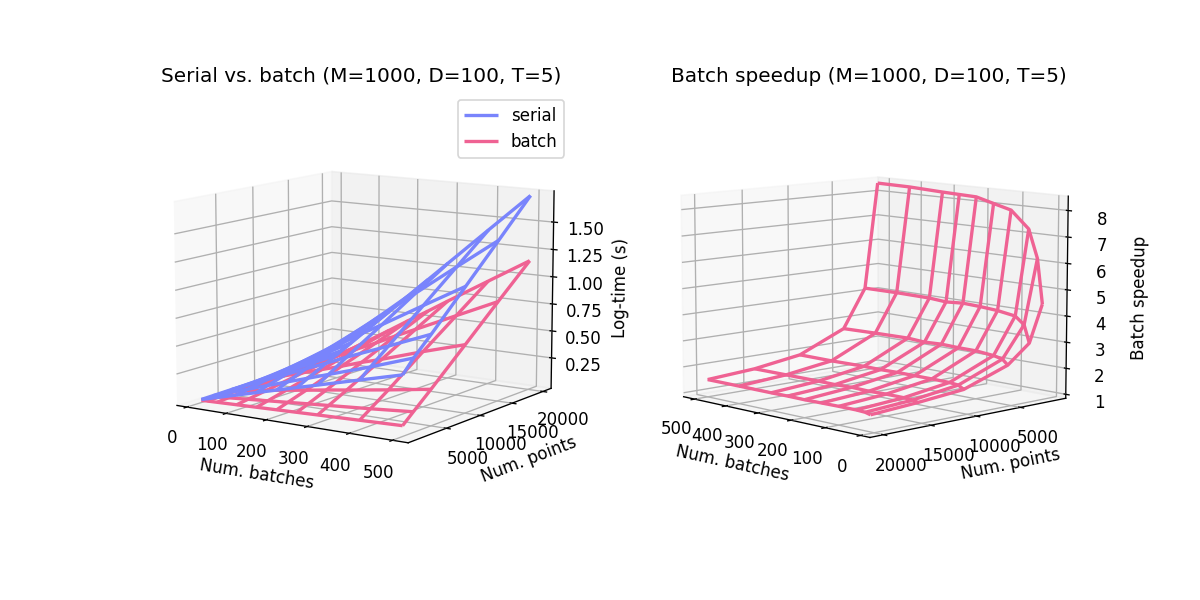

In [25]:
from matplotlib import cm
with plt.style.context("seaborn-pastel"):
    fig, ax = plt.subplots(ncols=2, subplot_kw={"projection": "3d"}, figsize=(10, 5))
    X, Y = np.meshgrid(Bs, Ns)
    surf = ax[0].plot_wireframe(X, Y, serial_times.T, color="#7984fc",
                             linewidth=2, antialiased=True, label="serial")
    surf = ax[0].plot_wireframe(X, Y, batch_times.T, color="#ef6293",
                             linewidth=2, antialiased=True, label="batch")
    surf = ax[1].plot_wireframe(X, Y, serial_times.T / batch_times.T, color="#ef6293",
                             linewidth=2, antialiased=True, label="batch")
    ax[0].set_xlabel("Num. batches")
    ax[0].set_ylabel("Num. points")
    ax[0].set_zlabel("Log-time (s)")
    ax[1].set_xlabel("Num. batches")
    ax[1].set_ylabel("Num. points")
    ax[1].set_zlabel("Batch speedup")
    ax[1].set_zlim([1, ax[1].get_zlim()[1]])
    ax[0].legend(loc="best")
    ax[0].set_title("Serial vs. batch (M=1000, D=100, T=5)")
    ax[1].set_title("Batch speedup (M=1000, D=100, T=5)")
#     fig.tight_layout()

## Normal kernels (in-core)

In [140]:
from falkon.la_helpers.cuda_la_helpers import square_norm

In [153]:
norm_times = []
mm_times = []
mulexp_times = []
# @torch.jit.script
def squared_euclidean_distance(x1, x2):
    t_0 = time.time()
    x1_norm = torch.norm(x1, p=2, dim=-1, keepdim=True).pow_(2)  # N x 1
    x2_norm = torch.norm(x2, p=2, dim=-1, keepdim=True).pow_(2)  # M x 1
#     x1_norm = square_norm(x1, dim=-1, keepdim=True)
#     x2_norm = square_norm(x2, dim=-1, keepdim=True)
    torch.cuda.synchronize()
    t_1 = time.time()
    res = torch.addmm(x2_norm.transpose(-2, -1), x1, x2.transpose(-2, -1), alpha=-2).add_(x1_norm)
    torch.cuda.synchronize()
    t_2 = time.time()
    res = res.clamp_min_(1e-30)
    norm_times.append(t_1-t_0)
    mm_times.append(t_2-t_1)
    torch.cuda.synchronize()
    return res
# @torch.jit.script
def full_rbf_kernel(X1, X2, sigma):
    pairwise_dists = squared_euclidean_distance(X1 / sigma, X2 / sigma)
    t_3 = time.time()
    pairwise_dists.mul_(-0.5).exp_()
    torch.cuda.synchronize()
    t_4 = time.time()
    mulexp_times.append(t_4-t_3)
    return pairwise_dists

In [160]:
%%timeit
preds = torch.empty(num_parallel, N, 1, device=X.device)
for i in range(num_parallel):
    preds[i] = full_rbf_kernel(X[i], W[i], torch.tensor(1.0)) @ alpha[i]
torch.cuda.synchronize()

219 ms ± 8.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
print("Norm: %.2fms - MM: %.2fms - MulExp: %.2fms" % (
    np.mean(norm_times) * 1000, np.mean(mm_times) * 1000, np.mean(mulexp_times) * 1000))

Norm: 0.79ms - MM: 6.99ms - MulExp: 1.36ms


In [161]:
print("Norm: %.2fms - MM: %.2fms - MulExp: %.2fms" % (
    np.mean(norm_times) * 1000, np.mean(mm_times) * 1000, np.mean(mulexp_times) * 1000))

Norm: 0.97ms - MM: 8.02ms - MulExp: 1.50ms


## batch kernel (in-core)

In [96]:
@torch.jit.script
def batch_sqeuc(x1, x2):
    x1_norm = torch.norm(x1, p=2, dim=-1, keepdim=True).pow_(2)  # B x N x 1
    x2_norm = torch.norm(x2, p=2, dim=-1, keepdim=True).pow_(2)  # B x M x 1
    # B x 1 x M + (B x N x 1  @  B x 1 x M)
    res = torch.baddbmm(x2_norm.transpose(-2, -1), x1, x2.transpose(-2, -1), alpha=-2).add_(x1_norm)
    res = res.clamp_min_(1e-30)
    return res
@torch.jit.script
def batch_rbf_kernel(X1, X2, sigma):
    pairwise_dists = batch_sqeuc(X1 / sigma, X2 / sigma)
    return pairwise_dists.mul_(-0.5).exp_()

In [97]:
preds = batch_rbf_kernel(X, W, torch.tensor(1.0)) @ alpha
torch.cuda.synchronize()

In [98]:
%%timeit
preds = batch_rbf_kernel(X, W, torch.tensor(1.0)) @ alpha
torch.cuda.synchronize()

8.1 ms ± 9.09 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## batch kernel (keops)

In [49]:
from pykeops.torch import Genred
from pykeops.torch import LazyTensor

In [50]:
formula = f'Exp(IntInv(-2) * Sum(Square(Var(0,{D},0)/s - Var(1,{D},1)/s))) * Var(2,1,1)'
aliases = [
    f'Var(0,{D},0)',
    f'Var(1,{D},1)',
    'Var(2,1,1)',
    's = Pm(1)',
]

In [51]:
fn = Genred(formula, aliases, reduction_op='Sum', axis=1, dtype='float32',
            rec_multVar_highdim=None, enable_chunks=True)
variables = [X, W, alpha, torch.tensor([1.0], device=X.device).reshape(-1,1)]

In [56]:
%%timeit
preds2 = fn(*variables)

35.7 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
from falkon.kernels import GaussianKernel

In [12]:
kernel = GaussianKernel(1.0)

175 ms ± 28.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
